<a href="https://colab.research.google.com/github/JuanDa14Sa/Compiladores/blob/main/Analizador_syntax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Analizador sintáctico predictivo ascendente**
Juan David Sánchez Murcia\
Maria Paula Vizcaíno Forero

Importamos librerías correspondientes

In [51]:
!pip install anytree 

In [40]:
import pandas as pd
from collections import deque
from anytree import Node, RenderTree, util
from anytree.exporter import UniqueDotExporter
from IPython.display import Image

Definimos la estructura correspondiente a nuestra gramática: La cadena vacía es @ y las producciones se notan como  S->(A)

In [41]:
terminals=['(',')',';','x']
non_terminals=['S','A','C','B']
start_symbol='S'
grammar=['S->(A)',  
         'A->CB', 
         'B->;A|@', 
         'C->x|S']

productions_=[s.split('->') for s in grammar]
productions=dict([pair[0],pair[1].split('|')] for pair in productions_)

Definimos ahora *first* y *find_first* funciones las cuales corresponden a PRIMERO como su nombre lo indica

In [42]:
def first(alpha):
    first_set=set()
    if alpha in terminals or alpha =='@':
        first_set.add(alpha)
    elif alpha in non_terminals:
        alpha_prods=productions[alpha]
        for prod in alpha_prods: #Si hay más de una producción para un no terminal
            first_set_=first(prod)
            first_set.update(first_set_)
    else: #Es una producción del tipo alpha->y1y2...yk
        i=0
        y=alpha[0]
        y_first=first(y)
        if '@' in y_first:    #Encontre un epsilon en la primera, entonces calculo la siguiente
            i=1
            while '@' in y_first: #Calculo todas las y's hasta que en alguna salga un epsilon
               first_set.update(y_first)
               first_set.remove('@')
               first_set.update(alpha[i])
               i+=1
            if i == len(alpha):   #Epsilon aparece en todos los primeros
                first_set.add('@')
        else:
            first_set.update(y_first)
    return first_set

def find_first():
    first_={non_term:first(non_term) for non_term in non_terminals}
    return first_

Corremos *find_first*

In [43]:
find_first()

{'A': {'(', 'x'}, 'B': {';', '@'}, 'C': {'(', 'x'}, 'S': {'('}}

Análogamente, definimos ahora *find_follow* función la cual corresponde a SIGUIENTE como su nombre lo indica

In [44]:
def find_follow():
    follow={}
    for nonterminal in non_terminals:
        follow[nonterminal]=set()   
    follow[start_symbol].add('$')
    change=True
    while(change):
        change=False
        for non_term,prods in productions.items():
            for prod in prods:
                # nonterminal='A'
                for alpha in non_terminals:
                    if alpha in prod:
                        alpha_pos=prod.index(alpha)
                        if alpha_pos<len(prod)-1:  #Producción de la forma prod->a alpha beta
                            first_=first(prod[alpha_pos+1])
                            first_beta=first_
                            for i in range(alpha_pos+1,len(prod)):
                                first_=first(prod[i])  
                                first_beta=first_beta.intersection(first(prod[i]))
                            if not ((first_-set('@')).issubset(follow[alpha])): #Encontramos nuevos elementos para agregar
                                follow[alpha]=follow[alpha].union(first_-set('@'))
                                change=True
                            if not (prod[i] in non_terminals and '@' in first_beta) :
                                break
                            if '@' in first_beta:
                                if not (follow[non_term].issubset(follow[alpha])):
                                    follow[alpha]=follow[alpha].union(follow[non_term])
                                    change=True 
                        else: #Producción de la forma prod->a alpha 
                            if not (follow[non_term].issubset(follow[alpha])):
                                follow[alpha]=follow[alpha].union(follow[non_term])
                                change=True                                
    return follow

Corremos *find_follow*

In [45]:
find_follow()

{'A': {')'}, 'B': {')'}, 'C': {')', ';'}, 'S': {'$', ')', ';'}}

Continuamos con la generación de la tabla correspondiente a la gramática por medio de la función *parseTable*

In [46]:
def parseTable(grammar,terminals,non_terminals):
    terminals_=terminals
    terminals_.append('$')
    table_={non_term:{term:[] for term in terminals_ } for non_term in non_terminals}
    productions_=[s.split('->') for s in grammar]
    productions=dict([pair[0],pair[1].split('|')] for pair in productions_)
    follow_=find_follow()
    for A,prods in productions.items():
        for alpha in prods:
            first_alpha=first(alpha)
            for a in first_alpha:
                if a in terminals:
                    table_[A][a]='{}->{}'.format(A,alpha)
                elif a == '@':
                    follow_A=follow_[A]
                    for b in follow_A:
                        if b == '$':
                            table_[A][b]='{}->{}'.format(A,alpha)
                        table_[A][b]='{}->{}'.format(A,alpha)
    return table_               


Corremos *parseTable*

In [47]:
info=parseTable(grammar,terminals,non_terminals)
df=pd.DataFrame.from_dict(info,orient='index')
df

,(,),;,x,$
S,S->(A),[],[],[],[]
A,A->CB,[],[],A->CB,[]
C,C->S,[],[],C->x,[]
B,[],B->@,B->;A,[],[]


Continuamos con la definición de la función que simulara el parsing por medio de una pila, a la vez realizamos la construcción del árbol de parsing.

In [48]:
def parseStackTree(input):
    input=input+'$'
    stack=deque()
    stack.append('$')
    stack.append(start_symbol)
    root=Node(start_symbol)
    parent=root
    index=0
    a=input[index]
    X=stack[-1]
    while X!='$':
        if a not in terminals:
            raise Exception('Input no en el lenguaje')    
        if X==a:
            print('Matches {}'.format(stack.pop()))
            index+=1
            a=input[index]
            while (util.rightsibling(parent)== None and parent.parent!=root): #Subimos hasta que hallan otros nodos a la derecha
                parent=parent.parent
            parent=util.rightsibling(parent)  #Cambiamos al nodo de la derecha
        elif X in terminals:
            raise SyntaxError('No es una producciónd de la gramática')
        elif X=='@':
            stack.pop()
        elif df.loc[X,a]=='[]':
            raise Exception('Error')
        elif len(df.loc[X,a].split('->')):#Es una producción X->Y1Y2...      
            for y in df.loc[X,a].split('->')[1]:
                Node(y,parent)  
            stack.pop()
            print(df.loc[X,a])
            for y in reversed(df.loc[X,a].split('->')[1]):
                stack.append(y)
            # print(parent)
            if parent.name not in terminals:   
                parent=parent.children[0]
        X=stack[-1]
        print('Stack: ',stack)
        print('Input: ',input[index:])
    # for pre, fill, node in RenderTree(root, childiter=reversed):    
        # print("%s%s" % (pre, node.name))
    UniqueDotExporter(root).to_picture("root.png")    

Corremos *parseStackTree* para simular el parsing con entrada (x;(x))

In [49]:
parseStackTree('(x;(x))')

S->(A)
Stack:  deque(['$', ')', 'A', '('])
Input:  (x;(x))$
Matches (
Stack:  deque(['$', ')', 'A'])
Input:  x;(x))$
A->CB
Stack:  deque(['$', ')', 'B', 'C'])
Input:  x;(x))$
C->x
Stack:  deque(['$', ')', 'B', 'x'])
Input:  x;(x))$
Matches x
Stack:  deque(['$', ')', 'B'])
Input:  ;(x))$
B->;A
Stack:  deque(['$', ')', 'A', ';'])
Input:  ;(x))$
Matches ;
Stack:  deque(['$', ')', 'A'])
Input:  (x))$
A->CB
Stack:  deque(['$', ')', 'B', 'C'])
Input:  (x))$
C->S
Stack:  deque(['$', ')', 'B', 'S'])
Input:  (x))$
S->(A)
Stack:  deque(['$', ')', 'B', ')', 'A', '('])
Input:  (x))$
Matches (
Stack:  deque(['$', ')', 'B', ')', 'A'])
Input:  x))$
A->CB
Stack:  deque(['$', ')', 'B', ')', 'B', 'C'])
Input:  x))$
C->x
Stack:  deque(['$', ')', 'B', ')', 'B', 'x'])
Input:  x))$
Matches x
Stack:  deque(['$', ')', 'B', ')', 'B'])
Input:  ))$
B->@
Stack:  deque(['$', ')', 'B', ')', '@'])
Input:  ))$
Stack:  deque(['$', ')', 'B', ')'])
Input:  ))$
Matches )
Stack:  deque(['$', ')', 'B'])
Input:  )$
B->@
Sta

Finalmente desplegamos la imagen del árbol generado durante la simulación del parsing por medio de la pila

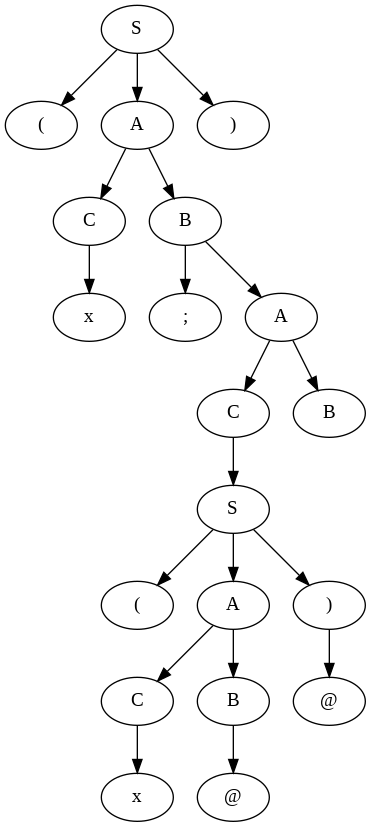

In [50]:
Image('root.png')